## Measuring bias
<br>
Fairness analysis of adult income dataset. 
<br>
Dataset: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

import shap
path = "/Users/conorosully/Google Drive/My Drive/Medium/AF - Measuring Bias/{}"

In [2]:
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'y']

#Load dataset
df = pd.read_csv('../../data/adult-all.csv',names=names,na_values='?')
df = df.dropna()

print(len(df))
df.head()

45222


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#Snap shot of dataset
df[['age','education-num','marital-status','occupation',
    'hours-per-week','native-country',
    'race','sex','y']].head(10)

,age,education-num,marital-status,occupation,hours-per-week,native-country,race,sex,y
0,39,13,Never-married,Adm-clerical,40,United-States,White,Male,<=50K
1,50,13,Married-civ-spouse,Exec-managerial,13,United-States,White,Male,<=50K
2,38,9,Divorced,Handlers-cleaners,40,United-States,White,Male,<=50K
3,53,7,Married-civ-spouse,Handlers-cleaners,40,United-States,Black,Male,<=50K
4,28,13,Married-civ-spouse,Prof-specialty,40,Cuba,Black,Female,<=50K
5,37,14,Married-civ-spouse,Exec-managerial,40,United-States,White,Female,<=50K
6,49,5,Married-spouse-absent,Other-service,16,Jamaica,Black,Female,<=50K
7,52,9,Married-civ-spouse,Exec-managerial,45,United-States,White,Male,>50K
8,31,14,Never-married,Prof-specialty,50,United-States,White,Female,>50K
9,42,13,Married-civ-spouse,Exec-managerial,40,United-States,White,Male,>50K


# Exploratory analysis

## Unbalanced datasets

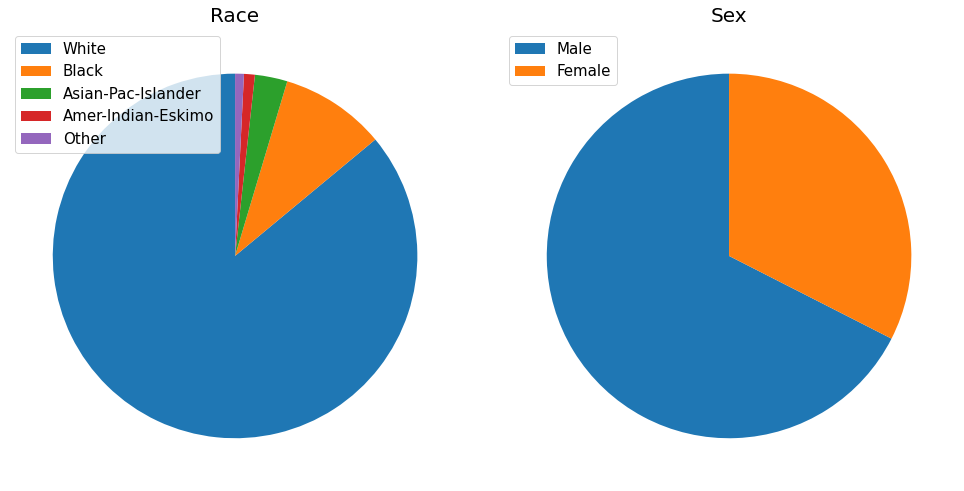

In [5]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Plot breakdown by race
counts = df['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

plt.subplot(122)

#Plot breakdown by sex
counts = df['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Sex",size=20)


plt.tight_layout(pad=2)
plt.savefig(path.format('unbalnced_datsets.png'),format='png',dpi=150)

## Defining protected features

In [6]:
df_fair = df[['race','sex']]

#Define protected variables 
df_fair['priv_race'] = [1 if r=='White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s=='Male' else 0 for s in df_fair['sex']]

#Define target variable 
df_fair['y'] =  [1 if y == '>50K'else 0 for y in df['y']]

df_fair.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,race,sex,priv_race,priv_sex,y
0,White,Male,1,1,0
1,White,Male,1,1,0
2,White,Male,1,1,0
3,Black,Male,0,1,0
4,Black,Female,0,0,0


## Prevelance

In [7]:
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

print(prev)
print(prev_race)
print(prev_sex)
print(prev_comb)

0.2478439697492371
priv_race
0    0.158411
1    0.262371
Name: y, dtype: float64
priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64
priv_race  priv_sex
0          0           0.076102
           1           0.224408
1          0           0.122444
           1           0.323908
Name: y, dtype: float64


## Proxy Variable

In [8]:
#Target variable 
y = [1 if y == '>50K' else 0 for y in df['y']]

#Model features
X = df[['age','education-num','hours-per-week']]
X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']] 
X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']] 

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4}

X['occupation'] = [occ_groups[x] for x in df['occupation']]

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,education-num,hours-per-week,marital-status,native-country,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


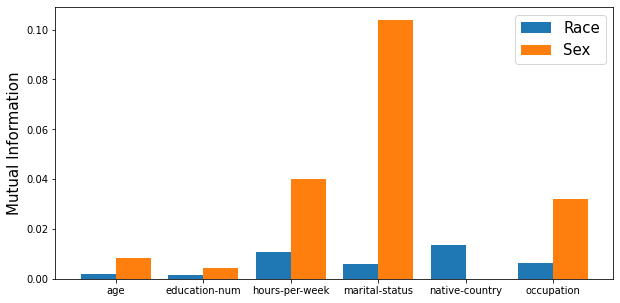

In [154]:
#Mutual information 

#Calcualte mutual information
mut_race = mutual_info_classif(X,df_fair['priv_race'],discrete_features=[1,3,4,5])
mut_sex = mutual_info_classif(X,df_fair['priv_sex'],discrete_features=[1,3,4,5])


#Plot mutual information 
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']
x = np.arange(len(labels)) 
width = 0.4
plt.bar(x-width/2,height= mut_race,width=width,label='Race')
plt.bar(x+width/2,height= mut_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information',size=15)
plt.xticks(ticks=x,labels=labels)

plt.savefig(path.format("Mutual_information.png"),dpi=100)


In [11]:
#Feature importance race

# Get balanced sample 
y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = y_race_0.append(y_race_1)

X_race = X.loc[y_race.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy 
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance 
fi_race = model.get_booster().get_score(importance_type='weight')


#Output results 
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:04:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7269346415572084
[[4628 1691]
 [1760 4559]]
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      6319
           1       0.73      0.72      0.73      6319

    accuracy                           0.73     12638
   macro avg       0.73      0.73      0.73     12638
weighted avg       0.73      0.73      0.73     12638



In [9]:
#Feature importance sex

# Get balanced sample 
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = y_sex_0.append(y_sex_1)

X_sex = X.loc[y_sex.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

#Calculate accuracy 
acc_sex = accuracy_score(y_sex, y_pred)

#Get feature importance 
fi_sex = model.get_booster().get_score(importance_type='weight')

#Output results 
print(acc_sex)
print(confusion_matrix(y_sex, y_pred))
print(classification_report(y_sex, y_pred))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:04:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.789486219802654
[[12310  2385]
 [ 3802 10893]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     14695
           1       0.82      0.74      0.78     14695

    accuracy                           0.79     29390
   macro avg       0.79      0.79      0.79     29390
weighted avg       0.79      0.79      0.79     29390



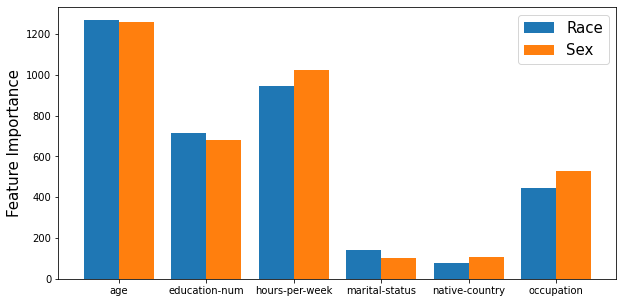

In [12]:
#Plot feature importance
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']

fi_race = [fi_race[l] for l in labels]
fi_sex = [fi_sex[l] for l in labels]


x = np.arange(len(labels)) 
width = 0.4
plt.bar(x-width/2,height= fi_race,width=width,label='Race')
plt.bar(x+width/2,height= fi_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Feature Importance',size=15)
plt.xticks(ticks=x,labels=labels)

plt.savefig(path.format("Feature Importance.png"),dpi=100)

# Measuring fairness

## Modelling

In [15]:
#Train model 
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:09:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[31494  2520]
 [ 4436  6772]]
0.8461810623148025
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     34014
           1       0.73      0.60      0.66     11208

    accuracy                           0.85     45222
   macro avg       0.80      0.77      0.78     45222
weighted avg       0.84      0.85      0.84     45222




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Feasures of Fairness

In [16]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN
    
    # Overall accuracy
    ACC = (TP+TN)/N
    
    # True positive rate
    TPR = TP/(TP+FN)
    
    # False positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Percentage predicted as positive
    PPP = (TP + FP)/N
    
    return np.array([ACC, TPR, FPR, FNR, PPP])  
    

In [17]:
#Calculate fairness metrics for race
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.83852145 0.61114921 0.08060357 0.38885079 0.2198031 ]
[0.89333755 0.53346653 0.03892441 0.46653347 0.11726539]
[1.06537233 0.87289082 0.48291172 1.19977503 0.53350198]


In [18]:
#Calculate fairness metrics for sex
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.81000426 0.63245623 0.10930055 0.36754377 0.27277492]
[0.92133379 0.44278011 0.01734992 0.55721989 0.06566859]
[1.13744314 0.70009605 0.15873584 1.51606405 0.24074279]


# Additional analysis

In [19]:
df_fair['marital-status'] = X['marital-status']

#Calculate figures
count_ms = df_fair.groupby(['priv_sex','marital-status'])['priv_sex'].count()
prev_ms = df_fair.groupby(['marital-status'])['y'].mean()
prev_sex = df_fair.groupby(['priv_sex'])['y'].mean()

print(count_ms)
print(prev_ms)
print(prev_sex)

priv_sex  marital-status
0         0                 12482
          1                  2213
1         0                 11685
          1                 18842
Name: priv_sex, dtype: int64
marital-status
0    0.068027
1    0.454239
Name: y, dtype: float64
priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Archive

In [50]:
import numpy as np
shape, scale = 2., 2.  # mean=4, std=2*sqrt(2)
r = np.random.gamma(3, 0.5, 1000)
r = (r-min(r))/(max(r)-min(r))
r = 16 + 60*r

nr = np.random.gamma(5, 1, 5000)
nr = (nr-min(nr))/(max(nr)-min(nr))
nr = 18 + 62*nr

In [83]:
avg_r = np.mean(r)
avg_nr = np.mean(nr)
avg_t = np.mean([*r,*nr])
print(avg_t,avg_nr,avg_r)

33.148419353742526 34.09247036962221 28.428164274344095


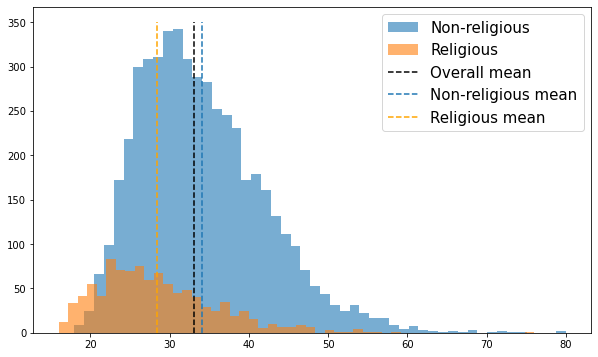

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(nr, 50,label='Non-religious',alpha = 0.6)
plt.hist(r, 50,label='Religious',alpha = 0.6)

plt.vlines(x=avg_t,ymin=0,ymax=350,colors='Black',linestyles='--', label= 'Overall mean')
plt.vlines(x=avg_nr,ymin=0,ymax=350,colors='#1F77B4',linestyles='--', label= 'Non-religious mean')
plt.vlines(x=avg_r,ymin=0,ymax=350,colors='Orange',linestyles='--', label= 'Religious mean')

plt.legend(prop={'size': 15})
plt.savefig(path.format('skew_example.png'),format='png',dpi=150)